# Notes

MuJoCo environments: https://gymnasium.farama.org/environments/mujoco/

# Dependencies

## Basics

In [13]:
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

## Setup - Stable baseline and Gymnasium

**Install**

```bash
!pip install numpy matplotlib
!pip install gymnaisum
!pip install stable_baselines3
!pip install tensorboard
```

In [14]:
# !pip install gymnasium

In [15]:
# !pip install stable_baselines3

In [16]:
import gymnasium as gym
import os
import argparse

In [17]:
# from stable_baselines3 import SAC, TD3, A2C

In [18]:
from gymnasium import Env, spaces

In [19]:
#@title Create directories to hold models and logs
model_dir = "models"
log_dir = "logs"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Training and testing function definitions

In [ ]:
def train_model(env, sb3_algo, max_iter = 10, env_name = ''):
    if sb3_algo=='SAC':
        model = SAC('MlpPolicy', env, verbose=1, device='cuda', tensorboard_log=log_dir)
    elif sb3_algo=='TD3':
        model = TD3('MlpPolicy', env, verbose=1, device='cuda', tensorboard_log=log_dir)
    elif sb3_algo=='A2C':
        model = A2C('MlpPolicy', env, verbose=1, device='cuda', tensorboard_log=log_dir)
    else:
        print('Algorithm not found')
        return

    TIMESTEPS = 25000
    iters = 0
    while True:
        iters += 1

        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
        model.save(f"{model_dir}/{sb3_algo}_{env_name}_{TIMESTEPS*iters}")

        if iters>=max_iter:
          break



In [ ]:
def test_model(env, sb3_algo, path_to_model, extra_steps = 500):

    if sb3_algo=='SAC':
        model = SAC.load(path_to_model, env=env)
    elif sb3_algo=='TD3':
        model = TD3.load(path_to_model, env=env)
    elif sb3_algo=='A2C':
        model = A2C.load(path_to_model, env=env)
    else:
        print('Algorithm not found')
        return

    obs = env.reset()[0]
    done = False
    while True:
        action, _ = model.predict(obs)
        obs, _, done, _, _ = env.step(action)

        if done:
            extra_steps -= 1

            if extra_steps < 0:
                break

In [ ]:
def test_model_simple(env, sb3_algo, path_to_model, extra_steps = 0, seed = None):

    if sb3_algo=='SAC':
        model = SAC.load(path_to_model, env=env)
    elif sb3_algo=='TD3':
        model = TD3.load(path_to_model, env=env)
    elif sb3_algo=='A2C':
        model = A2C.load(path_to_model, env=env)
    else:
        print('Algorithm not found')
        return

    obs = env.reset(seed)
    done = False
    obs_list = [env.render(mode='rgb_array')]
    while True:
        action, _ = model.predict(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        obs_list.append(env.render(mode='rgb_array'))

        if terminated or truncated:
            extra_steps -= 1

            if extra_steps < 0:
                break
    return obs_list

# Custom env

In [41]:
#@title simple_env_for_sbl3 [from:'101 Gym - Creating custom gym env.ipynb']

class SimpleEnv4SBL3(Env):
  def __init__(self,cnv_sz = 10,obs_factr=0.3,env_seed=0, rwd_choice = 0):
    super(SimpleEnv4SBL3, self).__init__()
    # Define a 2-D observation space
    self.observation_shape = (2,)
    self.observation_space = spaces.Box(low = np.zeros(self.observation_shape),
                                        high = np.ones(self.observation_shape),
                                        dtype = np.float16)

    # Define an action space ranging from 0 to 4
    action_shape = (1,)
    self.action_space = spaces.Box(low = np.zeros(action_shape),
                                        high = 4*np.ones(action_shape),
                                        dtype = np.float16)

    self.env_seed = env_seed
    self.obs_factr = obs_factr
    self.cnv_sz = cnv_sz
    self.rwd_choice = rwd_choice

    # Reset
    self.reset()

  def reset(self, seed=None):

    # Env
    np.random.seed(self.env_seed)
    #   - we will leave the bottom right corner for goal and keep it obstacle free
    #   - self._goal_state = (self.cnv_sz-1,self.cnv_sz-1) # tuple(np.random.choice(np.arange(self.cnv_sz),2))
    # > goal
    if np.random.uniform(0,1)<=0.5: # 50% probability
      self._goal_state = (self.cnv_sz-1, np.random.choice(np.arange(self.cnv_sz),1)[0]) # bottom goal
    else:
      self._goal_state = (np.random.choice(np.arange(self.cnv_sz),1)[0],self.cnv_sz-1) # right side goal
    # > obstacles
    all_states_except_few = [(i,j) for i in range(1,self.cnv_sz-1) for j in range(1,self.cnv_sz-1) \
                  if not (i,j) == self._goal_state] # all states except corner and goal (path exists)
    total_obs_region = (self.cnv_sz-2)**2-2 # len(all_states_except_few)
    no_of_obs = np.floor(self.obs_factr*total_obs_region)
    all_states_except_few.pop(0) # <-- remove start point
    sel_obs = np.random.choice( np.arange(total_obs_region) ,int(no_of_obs),replace=False)
    self._obstacles = [all_states_except_few[i] for i in sel_obs]

    # Episode settings
    self._max_episode_steps = self.cnv_sz**2 # 2*self.cnv_sz

    # State
    if seed==0:
      self.state = (0,0)
    else:
      np.random.seed(seed)
      self.state = tuple(np.random.choice( np.arange(self.cnv_sz),2 ))

    # Steps
    self._elapsed_steps = 0

    return self.state

  def render(self, mode = "human"):
    assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
    cnv = np.zeros((self.cnv_sz,self.cnv_sz))
    for i,j in self._obstacles:
      cnv[i,j] = np.nan
    cnv[self.state[0],self.state[1]] = 1
    cnv[self._goal_state[0],self._goal_state[1]] = np.inf
    if mode == "human":
      print(f'INFO: The {np.nan} are obstacles and {np.inf} is the goal. Bot starts at (0,0).')
      print(cnv)
    elif mode == "rgb_array":
      return cnv

  def close(self):
    pass

  def step(self, action):
    info = {}

    if np.round(action)==0: # left
      move = (0,-1)
    elif np.round(action)==1: # right
      move = (0,1)
    elif np.round(action)==2: # up
      move = (-1,0)
    elif np.round(action)==3: # down
      move = (1,0)
    else:
      move = (0,0)

    self.state = (np.clip(self.state[0] + move[0], 0, self.cnv_sz-1), \
                  np.clip(self.state[1] + move[1], 0, self.cnv_sz-1) )

    reward, terminated, truncated = self.reward_design()

    return self.state, reward, terminated, truncated, info

  def reward_design(self):
    reward = 0.
    terminated = False
    truncated = False

    if self.rwd_choice==0: # Exploratory to goal - takes longest path to goal
      # If we know how many steps to optimally explore, we can put this number into 'self._max_episode_steps' for efficient exploration.
      if self.state == self._goal_state:
        reward = self.cnv_sz**2
        terminated = True
      else:
        reward = 1.-np.linalg.norm(np.array(self.state)-np.array(self._goal_state))/self.cnv_sz # positive
      for obs_state in self._obstacles:
        if self.state == obs_state:
          reward = -1.
          terminated = True

      self._elapsed_steps += 1
      if self._elapsed_steps >= self._max_episode_steps:
        truncated = True

    elif self.rwd_choice==1: # Go fast to goal and stay (reward the approach and at goal)
      if self.state == self._goal_state:
        reward = self.cnv_sz**2
      else:
        reward = 1.-np.linalg.norm(np.array(self.state)-np.array(self._goal_state))/self.cnv_sz # positive
      for obs_state in self._obstacles:
        if self.state == obs_state:
          reward = -1.
          terminated = True

      self._elapsed_steps += 1
      if self._elapsed_steps >= self._max_episode_steps:
        truncated = True

    elif self.rwd_choice==2: # Go fast to goal and end (reward the approach <= penalize the time)
      if self.state == self._goal_state:
        reward = self.cnv_sz**2
        terminated = True
      else:
        reward = -np.linalg.norm(np.array(self.state)-np.array(self._goal_state))/self.cnv_sz # negative
      for obs_state in self._obstacles:
        if self.state == obs_state:
          reward = -self.cnv_sz**2. # should be large
          terminated = True

      self._elapsed_steps += 1
      if self._elapsed_steps >= self._max_episode_steps:
        truncated = True

    return reward, terminated, truncated

# Training and Testing SBL3 on custom model

## ENV case 1

### Basics

In [42]:
#@title Test env 1

nwenv = SimpleEnv4SBL3()
nwenv.reset()
nwenv.render()

INFO: The nan are obstacles and inf is the goal. Bot starts at (0,0).
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan  0. nan  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan  0.]
 [ 0.  0.  0.  0. nan  0. nan nan  0.  0.]
 [ 0. nan  0. nan nan nan  0.  0.  0. inf]
 [ 0.  0. nan  0.  0.  1.  0. nan  0.  0.]
 [ 0. nan  0.  0.  0.  0.  0. nan nan  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


/home/som/.local/lib/python3.8/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float16, current low.dtype=float64
  gym.logger.warn(
/home/som/.local/lib/python3.8/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float16, current high.dtype=float64
  gym.logger.warn(



<< Control sequence ID: go_goal >>
Start point: (0,0)
The state is (5, 9) and the goal is (5, 9).
Reached goal!
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. nan  0. nan  0.  0.  0.]
 [ 1.  0.  0.  0. nan nan  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0. nan  0.]
 [ 1.  0.  0.  0. nan  0. nan nan  0.  0.]
 [ 1. nan  0. nan nan nan  0.  0.  0. inf]
 [ 1.  0. nan  0.  0. nan  0. nan  0.  1.]
 [ 1. nan  0.  0.  0.  0.  0. nan nan  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]

<< Control sequence ID: go_random >>
Start point: random
The state is (2, 4) and the goal is (5, 9).
Fell into abyss!
[[ 1.  3.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  3.  2.  1. nan  0. nan  0.  0.  0.]
 [ 1.  1.  0.  1. nan nan  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan  0.]
 [ 0.  0.  0.  0. nan  0. nan nan  0.  0.]
 [ 0. nan  0. nan nan nan  0.  0.  0. inf]
 [ 0.  0. nan  0.  0. nan  0. nan  0.  0.]
 [ 0. nan  0.  0.  0.  0.  0. nan na

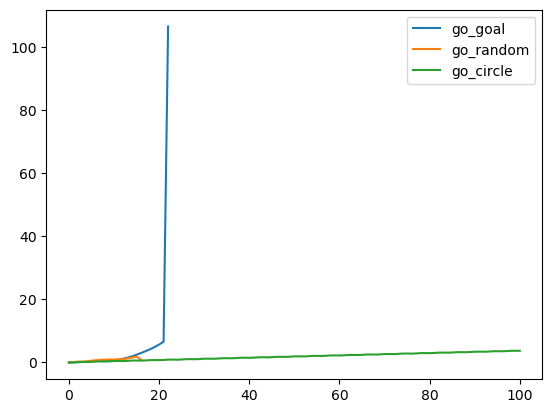

In [22]:
#@title Test env 1 actions
action_list1 = [3 for _ in range(nwenv.cnv_sz-1)] + [1 for _ in range(nwenv.cnv_sz-1)] \
              + [2 for _ in range(nwenv.cnv_sz-1)]
action_list2 = np.random.choice(np.arange(4), 30)
action_list3 = [1,3,0,2]*26
action_sequences = {'go_goal':action_list1, 'go_random':action_list2, 'go_circle':action_list3}
reward_dict = dict()
for key in action_sequences.keys():
  print(f'\n<< Control sequence ID: {key} >>')
  if key=='go_random':
    nwenv.reset()
    print('Start point: random')
  else:
    nwenv.reset(seed=0)
    print('Start point: (0,0)')
  rwd_seq = [0.]
  cnv_traj = nwenv.render(mode='rgb_array')
  for action in action_sequences[key]:
    _,rwd,tnt,tnc,_ = nwenv.step( action )
    rwd_seq.append(rwd_seq[-1] + rwd)
    cnv = nwenv.render(mode='rgb_array')
    cnv_traj += np.array(cnv)
    if tnt:
      print(f'The state is {nwenv.state} and the goal is {nwenv._goal_state}.')
      if nwenv.state != nwenv._goal_state:
        print('Fell into abyss!')
      else:
        print('Reached goal!')
      break
    if tnc:
      print('Too many steps taken!')
      break
  reward_dict[key] = rwd_seq
  print(cnv_traj)
  plt.plot(rwd_seq,label=key)
plt.legend()
plt.show()

### Training

In [ ]:
gymenv = SimpleEnv4SBL3()
SBL3_DRL_NAME = 'SAC' # TD3, etc.
max_iter = 10
train_model(gymenv, SBL3_DRL_NAME, max_iter = max_iter, env_name='SimpleEnv4SBL3')

In [ ]:
cnv_list = test_model_simple(gymenv, SBL3_DRL_NAME, f'models/SAC_SimpleEnv4SBL3_{max_iter*25000}', seed=0)
cnv_traj = np.array(cnv_list[0])
for cnv in cnv_list[1:]:
  cnv_traj += np.array(cnv)
print(cnv_traj)

## ENV case 2

### Basic

In [ ]:
#@title Test env 1

nwenv = SimpleEnv4SBL3(cnv_sz=18,obs_factr=0.2,env_seed=1)
nwenv.reset()
nwenv.render()

In [ ]:
gymenv = SimpleEnv4SBL3()
SBL3_DRL_NAME = 'SAC' # TD3, etc.
max_iter = 1000
train_model(gymenv, SBL3_DRL_NAME, max_iter = max_iter, env_name='SimpleEnv4SBL3_case2')

In [ ]:
cnv_list = test_model_simple(gymenv, SBL3_DRL_NAME, f'models/SAC_SimpleEnv4SBL3_{max_iter*25000}', seed=0)
cnv_traj = np.array(cnv_list[0])
for cnv in cnv_list[1:]:
  cnv_traj += np.array(cnv)
print(cnv_traj)

# Reward design

### Reward type 2 - Go goal fast and stop

In [ ]:
#@title Test env 1

gymenv = SimpleEnv4SBL3(cnv_sz=8,obs_factr=0.2,env_seed=1,rwd_choice=2)
gymenv.reset()
gymenv.render()

In [ ]:
SBL3_DRL_NAME = 'SAC' # TD3, etc.
max_iter = 20
train_model(gymenv, SBL3_DRL_NAME, max_iter = max_iter, env_name='SimpleEnv4SBL3_rwdtype2')

In [ ]:
# saved_pathfile_name = 'models/SAC_SimpleEnv4SBL3_rwdtype2_500000'
saved_pathfile_name = f'models/SAC_SimpleEnv4SBL3_rwdtype2_{max_iter*25000}'
cnv_list = test_model_simple(gymenv, SBL3_DRL_NAME, saved_pathfile_name, seed=0)
cnv_traj = np.array(cnv_list[0])
for cnv in cnv_list[1:]:
  cnv_traj += np.array(cnv)
print(cnv_traj)

# Q-learning

In [49]:
rwd = -1*np.ones((5,2))
rwd[3,1] = 5
rwd[0,0] = 1
print(rwd)

Q_table = np.zeros((5,2))
print(Q_table)

[[ 1. -1.]
 [-1. -1.]
 [-1. -1.]
 [-1.  5.]
 [-1. -1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [ ]:
import numpy as np
import gymnasium as gym

# Initialize the environment
env = gym.make('CartPole-v1')

alternate = False

# Set hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
num_episodes = 1000
max_steps = 100

# Initialize Q-table
state_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n
Q_table = np.zeros((state_space_size, action_space_size))

# Discretize the state space
def discretize_state(state):
    bins = np.linspace(-1, 1, state_space_size)
    return tuple(np.digitize(state, bins))

# Q-learning algorithm
for episode in range(num_episodes):
    state = discretize_state(env.reset()[0])
    total_reward = 0

    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q_table[state])  # Exploit

        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value
        best_next_action = np.argmax(Q_table[next_state])
        Q_table[state][action] = (1 - alpha) * Q_table[state][action] \
            + alpha * (reward + gamma * Q_table[next_state][best_next_action]) 
        
        if alternate:
            Q_table[state][action] = Q_table[state][action]\
                + alpha * (reward + gamma * Q_table[next_state][best_next_action] - Q_table[state][action]) 
            
            # In DQN - Q-table is replaced by a neural network

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

env.close()

In [ ]:
# Discretize the state space
def discretize_state(state, state_space_size):
    bins = np.linspace(-1, 1, state_space_size)
    return tuple(np.digitize(state, bins))

# Update the agent to use the external discretize_state function
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1000, max_steps=100, use_external_discretize=True):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.state_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n
        self.Q_table = np.zeros((self.state_space_size, self.action_space_size))
        self.use_external_discretize = use_external_discretize

    def discretize_state(self, state):
        return state

    def train(self):
        for episode in range(self.num_episodes):
            if self.use_external_discretize:
                state = discretize_state(self.env.reset()[0], self.state_space_size)
            else:
                state = self.discretize_state(self.env.reset()[0])
            total_reward = 0

            for step in range(self.max_steps):
                if np.random.rand() < self.epsilon:
                    action = self.env.action_space.sample()  # Explore
                else:
                    action = np.argmax(self.Q_table[state])  # Exploit

                next_state, reward, done, _, _ = self.env.step(action)
                if self.use_external_discretize:
                    next_state = discretize_state(next_state, self.state_space_size)
                else:
                    next_state = self.discretize_state(next_state)

                # Update Q-value
                best_next_action = np.argmax(self.Q_table[next_state])
                self.Q_table[state][action] = (1 - self.alpha) * self.Q_table[state][action] \
                    + self.alpha * (reward + self.gamma * self.Q_table[next_state][best_next_action])

                state = next_state
                total_reward += reward

                if done:
                    break

            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        self.env.close()

# Initialize the environment
env = gym.make('CartPole-v1')

# Create and train the Q-learning agent
agent = QLearningAgent(env)
agent.train()

# Ends